In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp

from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error

from GeneralRegression.GeneralRegression import GenericRegressor
from GeneralRegression.NpyProximation import HilbertRegressor, Measure
from GeneralRegression.extras import FunctionBasis
from datetime import datetime


import warnings

warnings.filterwarnings("ignore")

def mixed(X, p_d=3, f_d=1, l=1., e_d=2):
    points = []
    for x in X:
        point = []
        point.append(1.)
        for deg in range(1, f_d + 1):
            point.append(np.sin(deg * x[0] / l))
            point.append(np.cos(deg * x[0] / l))
        for deg in range(1, p_d + 1):
            point.append(x[0] ** deg)
        for deg in range(e_d + 1):
            point.append((x[0] ** deg) * np.exp(-x[0] / l))
            point.append((x[0] ** deg) * np.exp(x[0] / (2.5 * l)))
        points.append(np.array(point))
    return np.array(points)

def pfe_1d(p_d=3, f_d=1, l=1., e_d=2):
    basis = FunctionBasis()
    p_basis = basis.poly(1, p_d)
    f_basis = basis.fourier(1, f_d, l)[1:]
    e_basis = []
    for d in range(e_d + 1):
        e_basis.append(lambda x: (x ** d) * np.exp(-x / l))
        e_basis.append(lambda x: (x ** d) * np.exp(x / (2.5 * l)))
    return p_basis + f_basis + e_basis

def dt_parse(dt):
    if type(dt) is list:
        return [datetime.strptime(_, "%Y-%M") for _ in dt]
    return datetime.strptime(dt, "%Y-%m")


In [2]:
def plot_weight(X, Y, ci=None, W=None, lbls=[], fname='plt.png', ttl=None):
    import matplotlib.pyplot as plt
    from random import randint
    if W is not None:
        fig = plt.figure(randint(1, 10000), constrained_layout=True, figsize=(14, 12))
        gs = fig.add_gridspec(4, 1)
    else:
        fig = plt.figure(randint(1, 10000), constrained_layout=True, figsize=(14, 9))
        gs = fig.add_gridspec(3, 1)
    f_ax1 = fig.add_subplot(gs[:3, :])
    idx = 0
    for y in Y:
        f_ax1.plot(X, y, linewidth=2, label=lbls[idx])
        if ci is not None:
            if ci[idx] is not None:
                f_ax1.fill_between(X,
                               y - ci[idx],
                               y + ci[idx],
                               alpha=0.1)
        idx += 1
    f_ax1.legend(loc=2)
    f_ax1.grid(True, linestyle='-.', alpha=.2)
    if ttl is not None:
        f_ax1.set_title(ttl)
    if W is not None:
        f_ax2 = fig.add_subplot(gs[3, :])
        f_ax2.bar(X, W, label='Distibution', color='teal', alpha=.3)
        f_ax2.set_ylabel('Weight')
    plt.savefig(fname, dpi=200)

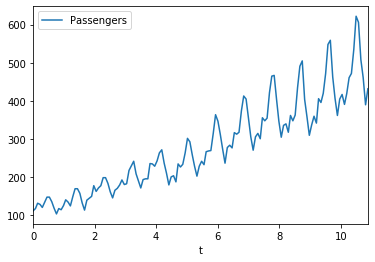

In [3]:
fname = "./data/airline.csv"
df = pd.read_csv(fname, parse_dates=[0], infer_datetime_format=True, date_parser=dt_parse)
init = df['Month'].min()
df['t'] = df.apply(lambda row, t0=init: (row['Month']-init).days/400., axis=1)
df.plot(x='t', y='Passengers')

In [16]:
from sklearn.model_selection import train_test_split
from copy import copy
X = df['t'].values#.reshape(-1, 1)
y = df['Passengers'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)
X_train_ = copy(X_train)
y_train_ = copy(y_train)
X_test_ = copy(X_test)
y_test_ = copy(y_test)
X_train, y_train = X_train.reshape(-1, 1), y_train#.reshape(-1, 1)

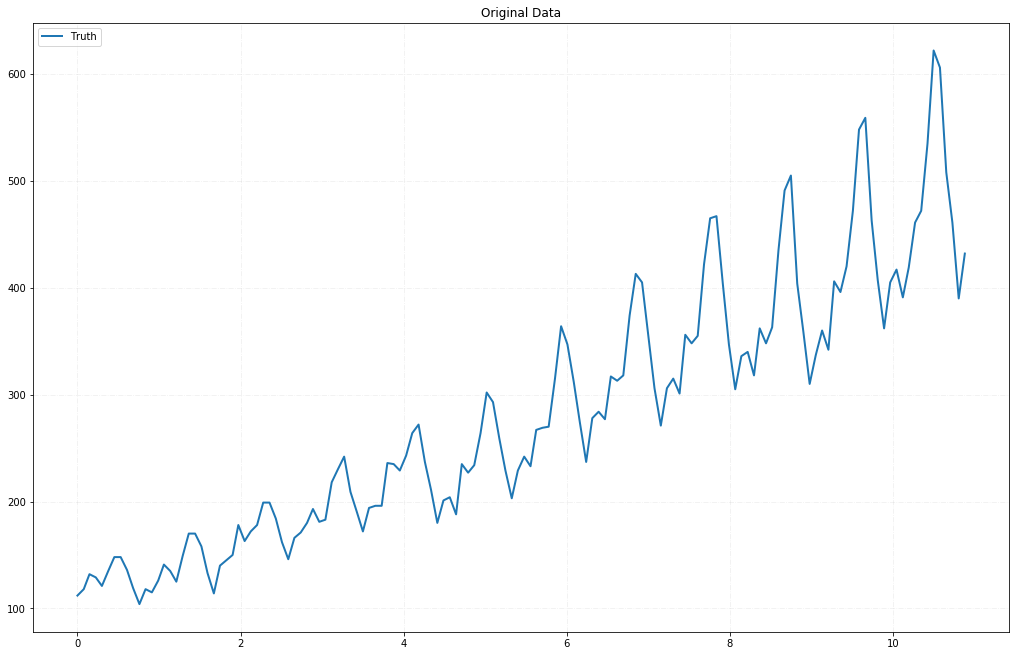

In [17]:
plot_weight(X, [y], W=None, lbls=['Truth'], fname='air_truth_plt.png', ttl='Original Data')

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100, 1), (100,), (44,), (44,))

Mean Square Error: 2099.508
Average expected loss: 1636.607
Average bias: 1567.563
Average variance: 69.044


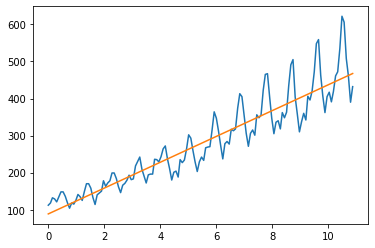

In [20]:
model0 = LinearRegression()
model0.fit(X_train, y_train_)
y_pred0 = model0.predict(X_test.reshape(-1, 1))
y_pred0_tot = model0.predict(X.reshape(-1, 1))
print("Mean Square Error: %.3f" % mean_squared_error(y, y_pred0_tot))
plt.plot(X, y)
plt.plot(X, y_pred0_tot)

avg_expected_loss0, avg_bias0, avg_var0 = bias_variance_decomp(
        model0, X_train, y_train, X_test.reshape(-1, 1), y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss0)
print('Average bias: %.3f' % avg_bias0)
print('Average variance: %.3f' % avg_var0)

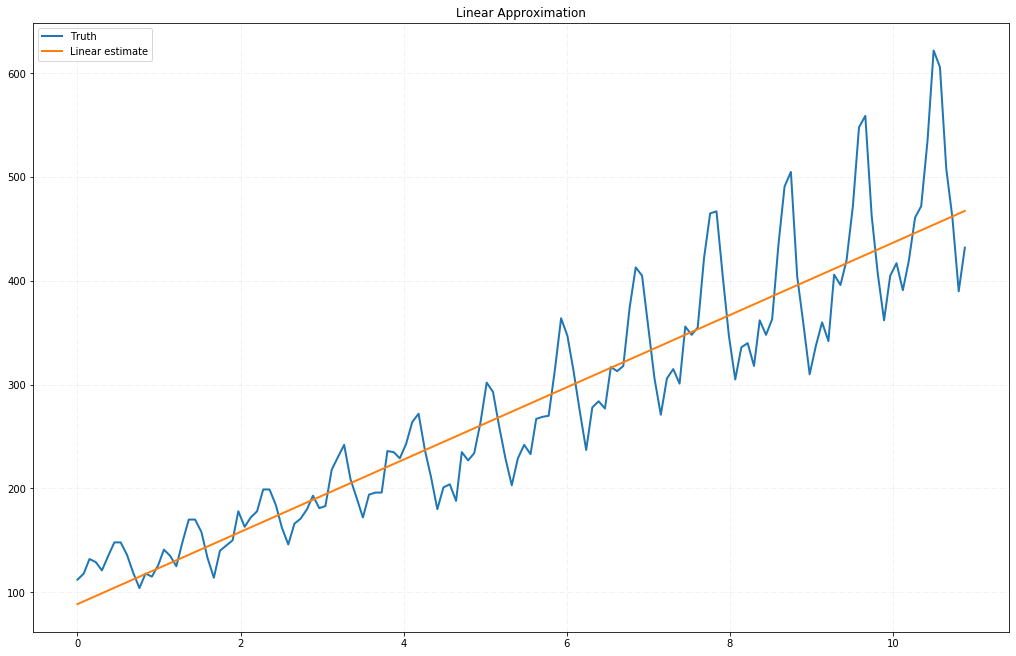

In [21]:
plot_weight(X, [y, y_pred0_tot], W=None, lbls=['Truth', 'Linear estimate'], fname='air_linear_plt.png', ttl='Linear Approximation')

Mean Square Error: 158.363
Average expected loss: 1336.904
Average bias: 543.322
Average variance: 793.582


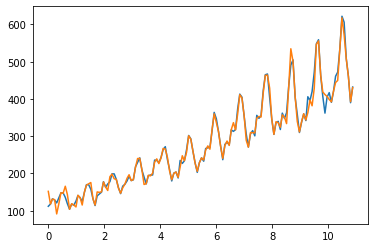

In [7]:
model1 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=50, l=1.75, e_d=0))
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test.reshape(-1, 1))
y_pred1_tot = model1.predict(X.reshape(-1, 1))
print("Mean Square Error: %.3f" % mean_squared_error(y, y_pred1_tot))
avg_expected_loss1, avg_bias1, avg_var1 = bias_variance_decomp(
        model1, X_train, y_train, X_test.reshape(-1, 1), y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss1)
print('Average bias: %.3f' % avg_bias1)
print('Average variance: %.3f' % avg_var1)
plt.plot(X, y)
plt.plot(X, y_pred1_tot)

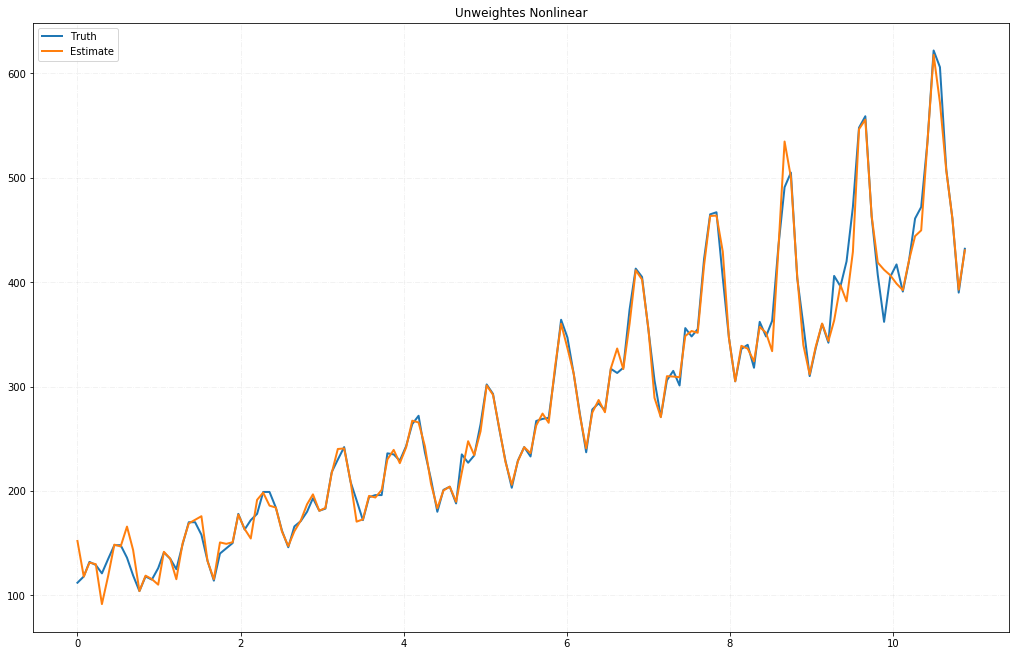

In [8]:
plot_weight(X, [y, y_pred1_tot], W=None, lbls=['Truth', 'Estimate'], fname='air_no_w_plt.png', ttl='Unweightes Nonlinear')

Mean Square Error: 5428.467
Weighted Mean Square Error: 1706.339
Average expected loss: 47150.102
Average bias: 29667.104
Average variance: 17482.999


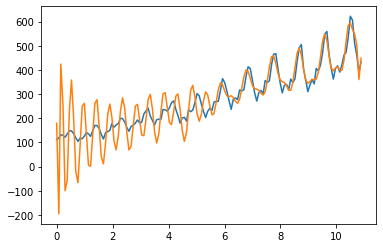

In [22]:
x_min, x_max = X.min(), X.max()
x_thrshld = x_min + 2 * (x_max - x_min) / 4.
# w_min + (w_max - w_min) * (_[0] - x_min) / (x_max - x_min)  # if _[0]<.8 * x_max else 10.
ws = {_: .1 if _ < x_thrshld else 1. for _ in X}
Xs = [_ for _ in X]
Ws = [ws[_] for _ in Xs]
meas = Measure(ws)
B1 = pfe_1d(p_d=1, f_d=25, l=2, e_d=-1)
model2 = HilbertRegressor(base=B1, meas=meas)
model2.fit(X, y)
y_pred2 = model2.predict(X_test.reshape(-1, 1))
y_pred2_tot = model2.predict(X.reshape(-1, 1))
print("Mean Square Error: %.3f" % mean_squared_error(y, y_pred2_tot))
print("Weighted Mean Square Error: %.3f" % mean_squared_error(y, y_pred2_tot, sample_weight=Ws))
avg_expected_loss2, avg_bias2, avg_var2 = bias_variance_decomp(
        model2, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss2)
print('Average bias: %.3f' % avg_bias2)
print('Average variance: %.3f' % avg_var2)
plt.plot(X, y)
plt.plot(X, y_pred2_tot)

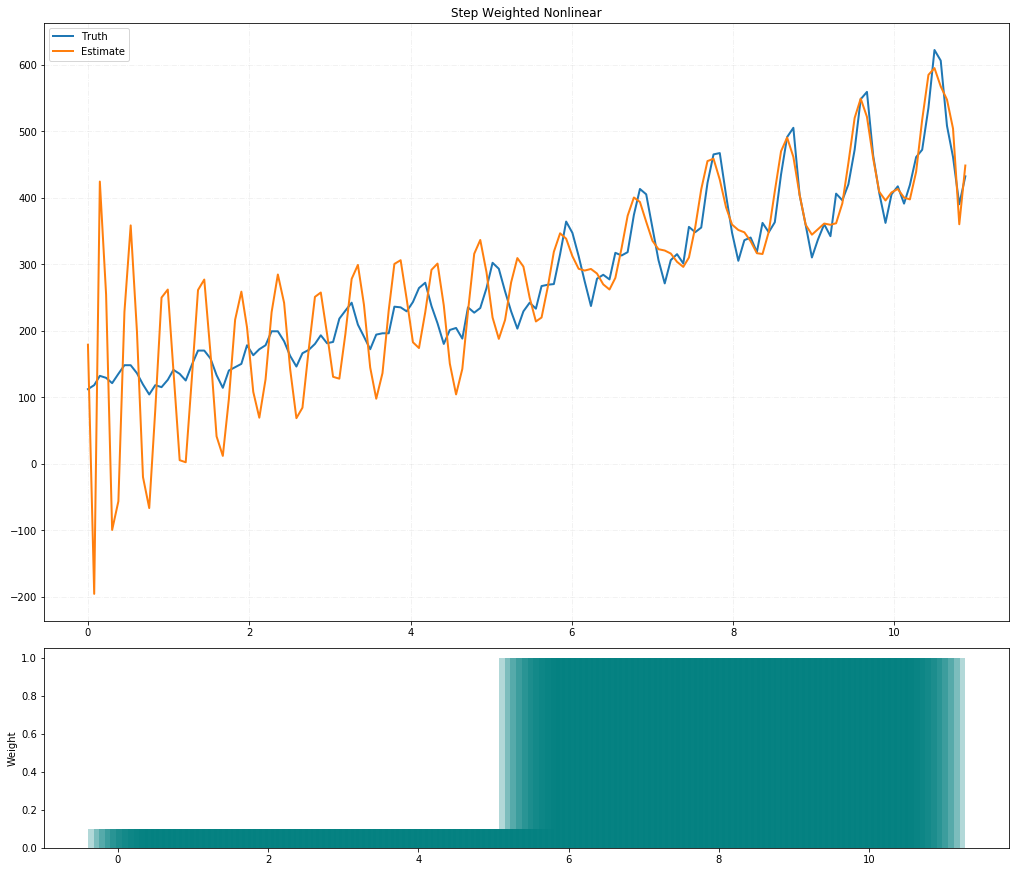

In [23]:
ws = {_: .1 if _ < x_thrshld else 1. for _ in X}
Xs = [_ for _ in X]
Ws = [ws[_] for _ in Xs]

plot_weight(X, [y, y_pred2_tot], W=Ws, lbls=['Truth', 'Estimate'], fname='air_step_w_plt.png', ttl="Step Weighted Nonlinear")

Mean Square Error: 4954.683
Weighted Mean Square Error: 2018.470
Average expected loss: 45422.420
Average bias: 29121.102
Average variance: 16301.319


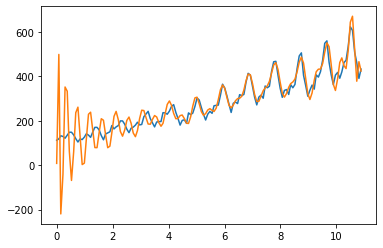

In [26]:
x_min, x_max = X.min(), X.max()
x_thrshld = x_min + 2 * (x_max - x_min) / 4.
w_min, w_max = .1, 1.
ws = {_: w_min + (w_max - w_min) * (_ - x_min) / (x_max - x_min) for _ in X}
Xs = [_ for _ in X]
Ws = [ws[_] for _ in Xs]
meas = Measure(ws)
B1 = pfe_1d(p_d=1, f_d=25, l=2, e_d=-1)
model3 = HilbertRegressor(base=B1, meas=meas)
model3.fit(X, y)
y_pred3 = model3.predict(X_test.reshape(-1, 1))
y_pred3_tot = model3.predict(X.reshape(-1, 1))
print("Mean Square Error: %.3f" % mean_squared_error(y, y_pred3_tot))
print("Weighted Mean Square Error: %.3f" % mean_squared_error(y, y_pred3_tot, sample_weight=Ws))
avg_expected_loss3, avg_bias3, avg_var3 = bias_variance_decomp(
        model3, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss3)
print('Average bias: %.3f' % avg_bias3)
print('Average variance: %.3f' % avg_var3)
plt.plot(X, y)
plt.plot(X, y_pred3_tot)

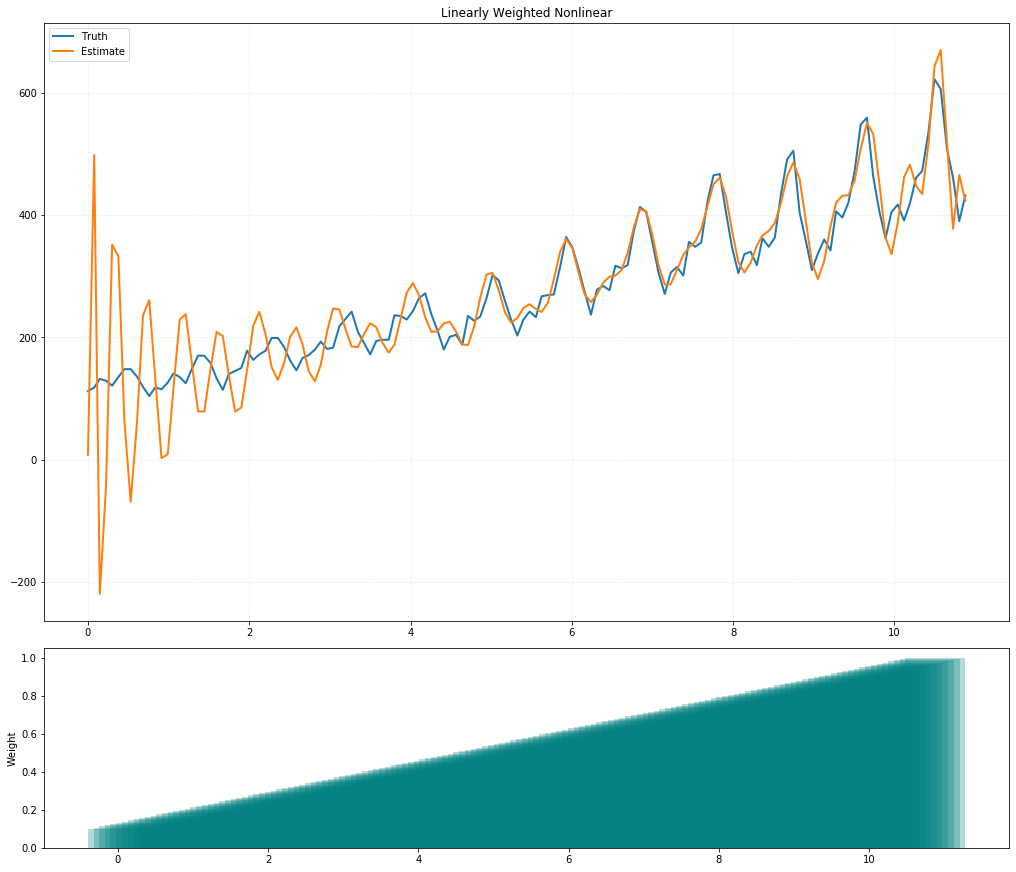

In [25]:
ws = {_: w_min + (w_max - w_min) * (_ - x_min) / (x_max - x_min) for _ in X}
Xs = [_ for _ in X]
Ws = [ws[_] for _ in Xs]
plot_weight(X, [y, y_pred3_tot], W=Ws, lbls=['Truth', 'Estimate'], fname='air_lin_w_plt.png', ttl='Linearly Weighted Nonlinear')

In [29]:
print("Mean Square Error: %.3f" % mean_squared_error(y_test, y_pred0))
print("Mean Square Error: %.3f" % mean_squared_error(y_test, y_pred1))
print("Mean Square Error: %.3f" % mean_squared_error(y_test, y_pred2))
print("Mean Square Error: %.3f" % mean_squared_error(y_test, y_pred3))

Mean Square Error: 1555.369
Mean Square Error: 500.445
Mean Square Error: 5299.838
Mean Square Error: 4453.818
